In [1]:
import torch
from models import baselines
import numpy as np
import evaluation.evaluation as ev
import training.training as tt
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import networkx as nx
from scipy import stats
from torch_geometric.utils.convert import from_networkx
from torch_geometric.datasets import TUDataset
import torch_geometric

### Load the graphs

In [2]:
# load some example dataset
dataset = TUDataset(root='data/TUDataset', name='MUTAG')
# covnert the dataset to networkx 
dataset_nx = np.array([torch_geometric.utils.to_networkx(data, to_undirected = True, node_attrs= ["x"]) for data in dataset])


print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


/tmp/ipykernel_14744/3658682324.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataset_nx = np.array([torch_geometric.utils.to_networkx(data, to_undirected = True, node_attrs= ["x"]) for data in dataset])


### Perform some aggregation over the nodes such that we end up with a single feature vector per graph.

In [3]:

# add two features for number of edges and nodes
x_data = np.zeros((len(dataset), dataset.num_features + 2))
y_data = np.zeros((len(dataset),))

# perform mean aggregation (maybe max/min/std would lead to better results)
for i, data in enumerate(dataset):
    x_data[i,:-2] = data.x.mean(0)
    x_data[i,-2] = data.num_nodes
    x_data[i,-1] = data.num_edges
    y_data[i] = data.y.detach().numpy()


train_mask = np.random.choice(np.arange(0, len(dataset)), size= int(len(dataset)*0.8), replace = False)
test_mask = np.delete(np.arange(0, len(dataset)), train_mask)

In [4]:

#define a grid Search function to find the optimal parameter setting
def gridSearch(model, dataX, dataY, grid_list, train_mask, validation_mask):
    opt_mod = None
    max_acc = 0
    opt_bal_acc = 0
    for i, setting in enumerate(grid_list):
        clf = model(dataX, dataY,**setting)
        clf.fit(train_mask)
        pred_test = clf.predict(validation_mask)
        acc = accuracy_score(clf.y[validation_mask], pred_test)
        bal_acc = balanced_accuracy_score(clf.y[validation_mask], pred_test)
        if acc > max_acc:
            max_acc = acc
            opt_mod = setting
            opt_bal_acc = bal_acc
    return opt_mod, max_acc, opt_bal_acc

# Random Forest

### Grid search for the optimal RF model

In [5]:

param_grid_rf = {'max_depth': [7, 8, 9, 10], 'max_features': ["sqrt", "log2"]}
grid_list_rf = list(ParameterGrid(param_grid_rf))


opt_mod_rf, max_acc_rf, opt_bal_acc_rf =  gridSearch(baselines.RandomForest, x_data, y_data, grid_list_rf, train_mask, test_mask)

print(opt_mod_rf)
print(max_acc_rf)
print(opt_bal_acc_rf)

{'max_depth': 7, 'max_features': 'sqrt'}
0.9210526315789473
0.9464285714285714


Test Set Accuracy and Balanced Accuracy
Test Accuracy: 0.8947
Test Balanced Accuracy: 0.8964
Train Accuracy: 0.9400
Train Balanced Accuracy: 0.9365


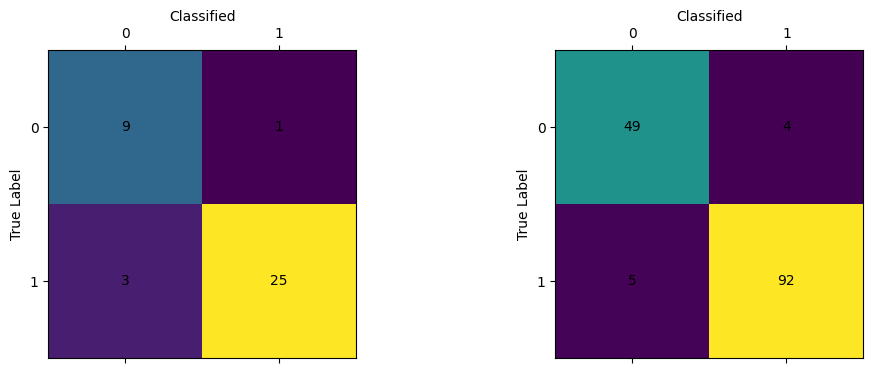

In [12]:

clf_rf = baselines.RandomForest(x_data, y_data, **opt_mod_rf)

clf_rf.fit(train_mask)
pred_test = clf_rf.predict(test_mask)
pred_train = clf_rf.predict(train_mask)

fig, ax = plt.subplots(1,2, figsize = (12,4))


ev.plot_confusion_matrix(clf_rf.y[test_mask], pred_test, [0,1], ax = ax[0])
#print(ev.eval_roc_auc(clf_rf.y[test_mask], pred_test))

print("Test Set Accuracy and Balanced Accuracy")
print(f"Test Accuracy: {accuracy_score(clf_rf.y[test_mask], pred_test):.4f}")
print(f"Test Balanced Accuracy: {balanced_accuracy_score(clf_rf.y[test_mask], pred_test):.4f}")


ev.plot_confusion_matrix(clf_rf.y[train_mask], pred_train, [0,1],ax = ax[1])
print(f"Train Accuracy: {accuracy_score(clf_rf.y[train_mask], pred_train):.4f}")
print(f"Train Balanced Accuracy: {balanced_accuracy_score(clf_rf.y[train_mask], pred_train):.4f}")



# Support Vector Machine

### Grid search for the optimal support vector machine model

In [14]:
param_grid_svc = {'C': [1, 100, 10000], 'kernel': ["linear", "rbf"]}
grid_list_svc = list(ParameterGrid(param_grid_svc))

opt_mod_svm, max_acc_svm, opt_bal_acc_svm =  gridSearch(baselines.SVM, x_data, y_data, grid_list_svc, train_mask, test_mask)

# {'C': 10000, 'kernel': 'linear'}
#0.5598039215686275
#0.44860112286408277

print(opt_mod_svm)
print(max_acc_svm)
print(opt_bal_acc_svm)

{'C': 1, 'kernel': 'linear'}
0.868421052631579
0.8785714285714286


Test Set Accuracy and Balanced Accuracy
Test Accuracy: 0.8684
Test Balanced Accuracy: 0.8786
Train Accuracy: 0.8800
Train Balanced Accuracy: 0.8815


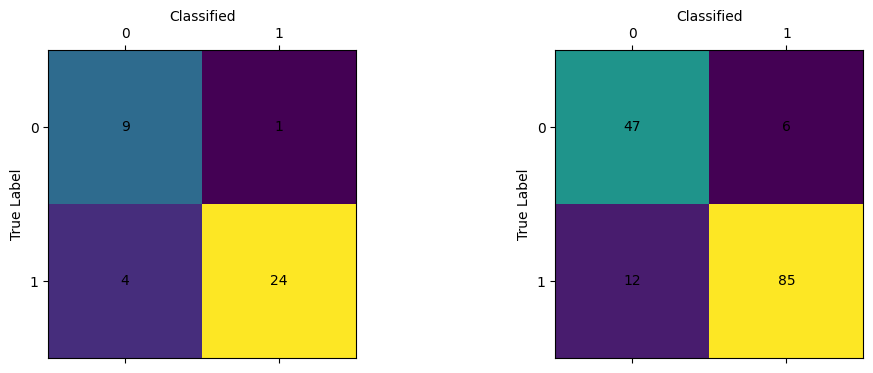

In [15]:

clf_svm = baselines.SVM(x_data, y_data, **opt_mod_svm)

clf_svm.fit(train_mask)
pred_test = clf_svm.predict(test_mask)
pred_train = clf_svm.predict(train_mask)

fig, ax = plt.subplots(1,2, figsize = (12,4))


ev.plot_confusion_matrix(clf_svm.y[test_mask], pred_test, [0,1], ax = ax[0])
#print(ev.eval_roc_auc(clf_svm.y[test_mask], pred_test))

print("Test Set Accuracy and Balanced Accuracy")
print(f"Test Accuracy: {accuracy_score(clf_svm.y[test_mask], pred_test):.4f}")
print(f"Test Balanced Accuracy: {balanced_accuracy_score(clf_svm.y[test_mask], pred_test):.4f}")


ev.plot_confusion_matrix(clf_svm.y[train_mask], pred_train, [0,1],ax = ax[1])
print(f"Train Accuracy: {accuracy_score(clf_svm.y[train_mask], pred_train):.4f}")
print(f"Train Balanced Accuracy: {balanced_accuracy_score(clf_svm.y[train_mask], pred_train):.4f}")

